In [1]:
from src.utils import load_data
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer

import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import wordnet
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [2]:
jobs = load_data(kind="processed")

# Define the pos_tagger function
def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

data = jobs[['id', 'description']]

## Categorization

In [3]:
# Categorize words in the 'description' column using a lambda function
# The lambda function applies part-of-speech tagging and uses a custom 'pos_tagger' function
# The result is a list of tuples, each containing a word and its corresponding part-of-speech category
# Words are filtered to exclude those with an undefined or None part-of-speech tag
data['description_categorized'] = data['description'].apply(
    lambda x: [(word, pos_tagger(tag[1][0].upper())) for word, tag in zip(eval(x), nltk.pos_tag(eval(x))) if pos_tagger(tag[1][0].upper()) is not None]
)

# Create a new column 'description_adjective' by extracting adjectives from the 'description' column
# The lambda function applies part-of-speech tagging and uses a custom 'pos_tagger' function
# The result is a list of adjectives filtered from the original words
# Words are filtered to exclude those with an undefined or None part-of-speech tag
data['description_adjective'] = data['description'].apply(
    lambda x: [word for word, pos_tag in [(word, pos_tagger(tag[1][0].upper())) for word, tag in zip(eval(x), nltk.pos_tag(eval(x))) if pos_tagger(tag[1][0].upper()) == wordnet.ADJ] if pos_tag is not None]
)

# create a new column 'description_noun' using the 'apply' function
# for each text description in the 'description' column:
data['description_noun'] = data['description'].apply(
    # use a lambda function to extract nouns using POS tagging
    lambda x: [
        word  # extract the word
        for word, pos_tag in [
            (word, pos_tagger(tag[1][0].upper()))  # POS tag each word
            for word, tag in zip(eval(x), nltk.pos_tag(eval(x)))  # pair each word with its POS tag
            if pos_tagger(tag[1][0].upper()) == wordnet.NOUN  # filter for nouns
        ]
        if pos_tag is not None  # exclude words with undefined POS tags
    ]
)

data['description_verb'] = data['description'].apply(lambda x: [word for word, pos_tag in [(word, pos_tagger(tag[1][0].upper())) for word, tag in zip(eval(x), nltk.pos_tag(eval(x))) if pos_tagger(tag[1][0].upper()) == wordnet.VERB] if pos_tag is not None])

data['location_scraped'] = jobs['location_scraped']
locations = data['location_scraped']
description_adj = data['description_adjective']
description_noun = data['description_noun']
description_verb = data['description_verb']

/var/folders/rb/kd_jtytn23s8cqfkvty6zp5r0000gp/T/ipykernel_30424/3822729054.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['description_categorized'] = data['description'].apply(
/var/folders/rb/kd_jtytn23s8cqfkvty6zp5r0000gp/T/ipykernel_30424/3822729054.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['description_adjective'] = data['description'].apply(
/var/folders/rb/kd_jtytn23s8cqfkvty6zp5r0000gp/T/ipykernel_30424/3822729054.py:19: SettingWithCopyWarning: 
A value is trying to be set

## TF-IDF

In [4]:
#description_adj is a list of text descriptions
#convert it to a list of strings
description_adj_strings = [' '.join(description) for description in description_adj]
description_noun_strings = [' '.join(description) for description in description_noun]
description_verb_strings = [' '.join(description) for description in description_verb]

from sklearn.feature_extraction.text import TfidfVectorizer


# create a TF-IDF vectorizer
vectorizer = TfidfVectorizer()

def get_tfidf_vectors(description_type):
    """
    Get TF-IDF vectors and keywords for each description.

    Parameters:
    - description_type: List of text descriptions.

    Returns:
    - vectors: TF-IDF vectors.
    - all_keywords: List of keywords for each description.
    """
    # create a TF-IDF vectorizer
#    vectorizer = TfidfVectorizer()
    
    # fit and transform the text descriptions using the TF-IDF vectorizer
    vectors = vectorizer.fit_transform(description_type)

    # get the feature names (words) corresponding to the TF-IDF vectors
    feature_names = vectorizer.get_feature_names_out()

    # convert the sparse TF-IDF matrix to a dense representation
    dense = vectors.todense()
    denselist = dense.tolist()

    # initialize a list to store keywords for each description
    all_keywords = []

    # iterate through each description in the dense representation
    for description in denselist:
        # extract keywords (feature names) where the TF-IDF value is greater than 0
        keywords = [feature_names[i] for i, word in enumerate(description) if word > 0]

        # append the keywords for the current description to the list
        all_keywords.append(keywords)

    return vectors, all_keywords



## KMEANS

In [5]:
# Get job locations and define colors for each cluster
locations = jobs['location_scraped']
colors = [
    "#FF5733",  # Orange
    "#33FF57",  # Green
    "#5733FF",  # Blue
    "#FF33B8",  # Pink
    "#B833FF",  # Purple
]

# Set the number of clusters for K-Means
true_k = 5

# Initialize K-Means model with specified parameters
model = KMeans(n_clusters=true_k, init="k-means++", max_iter=100, n_init=1)

## KMEANS - ADJ

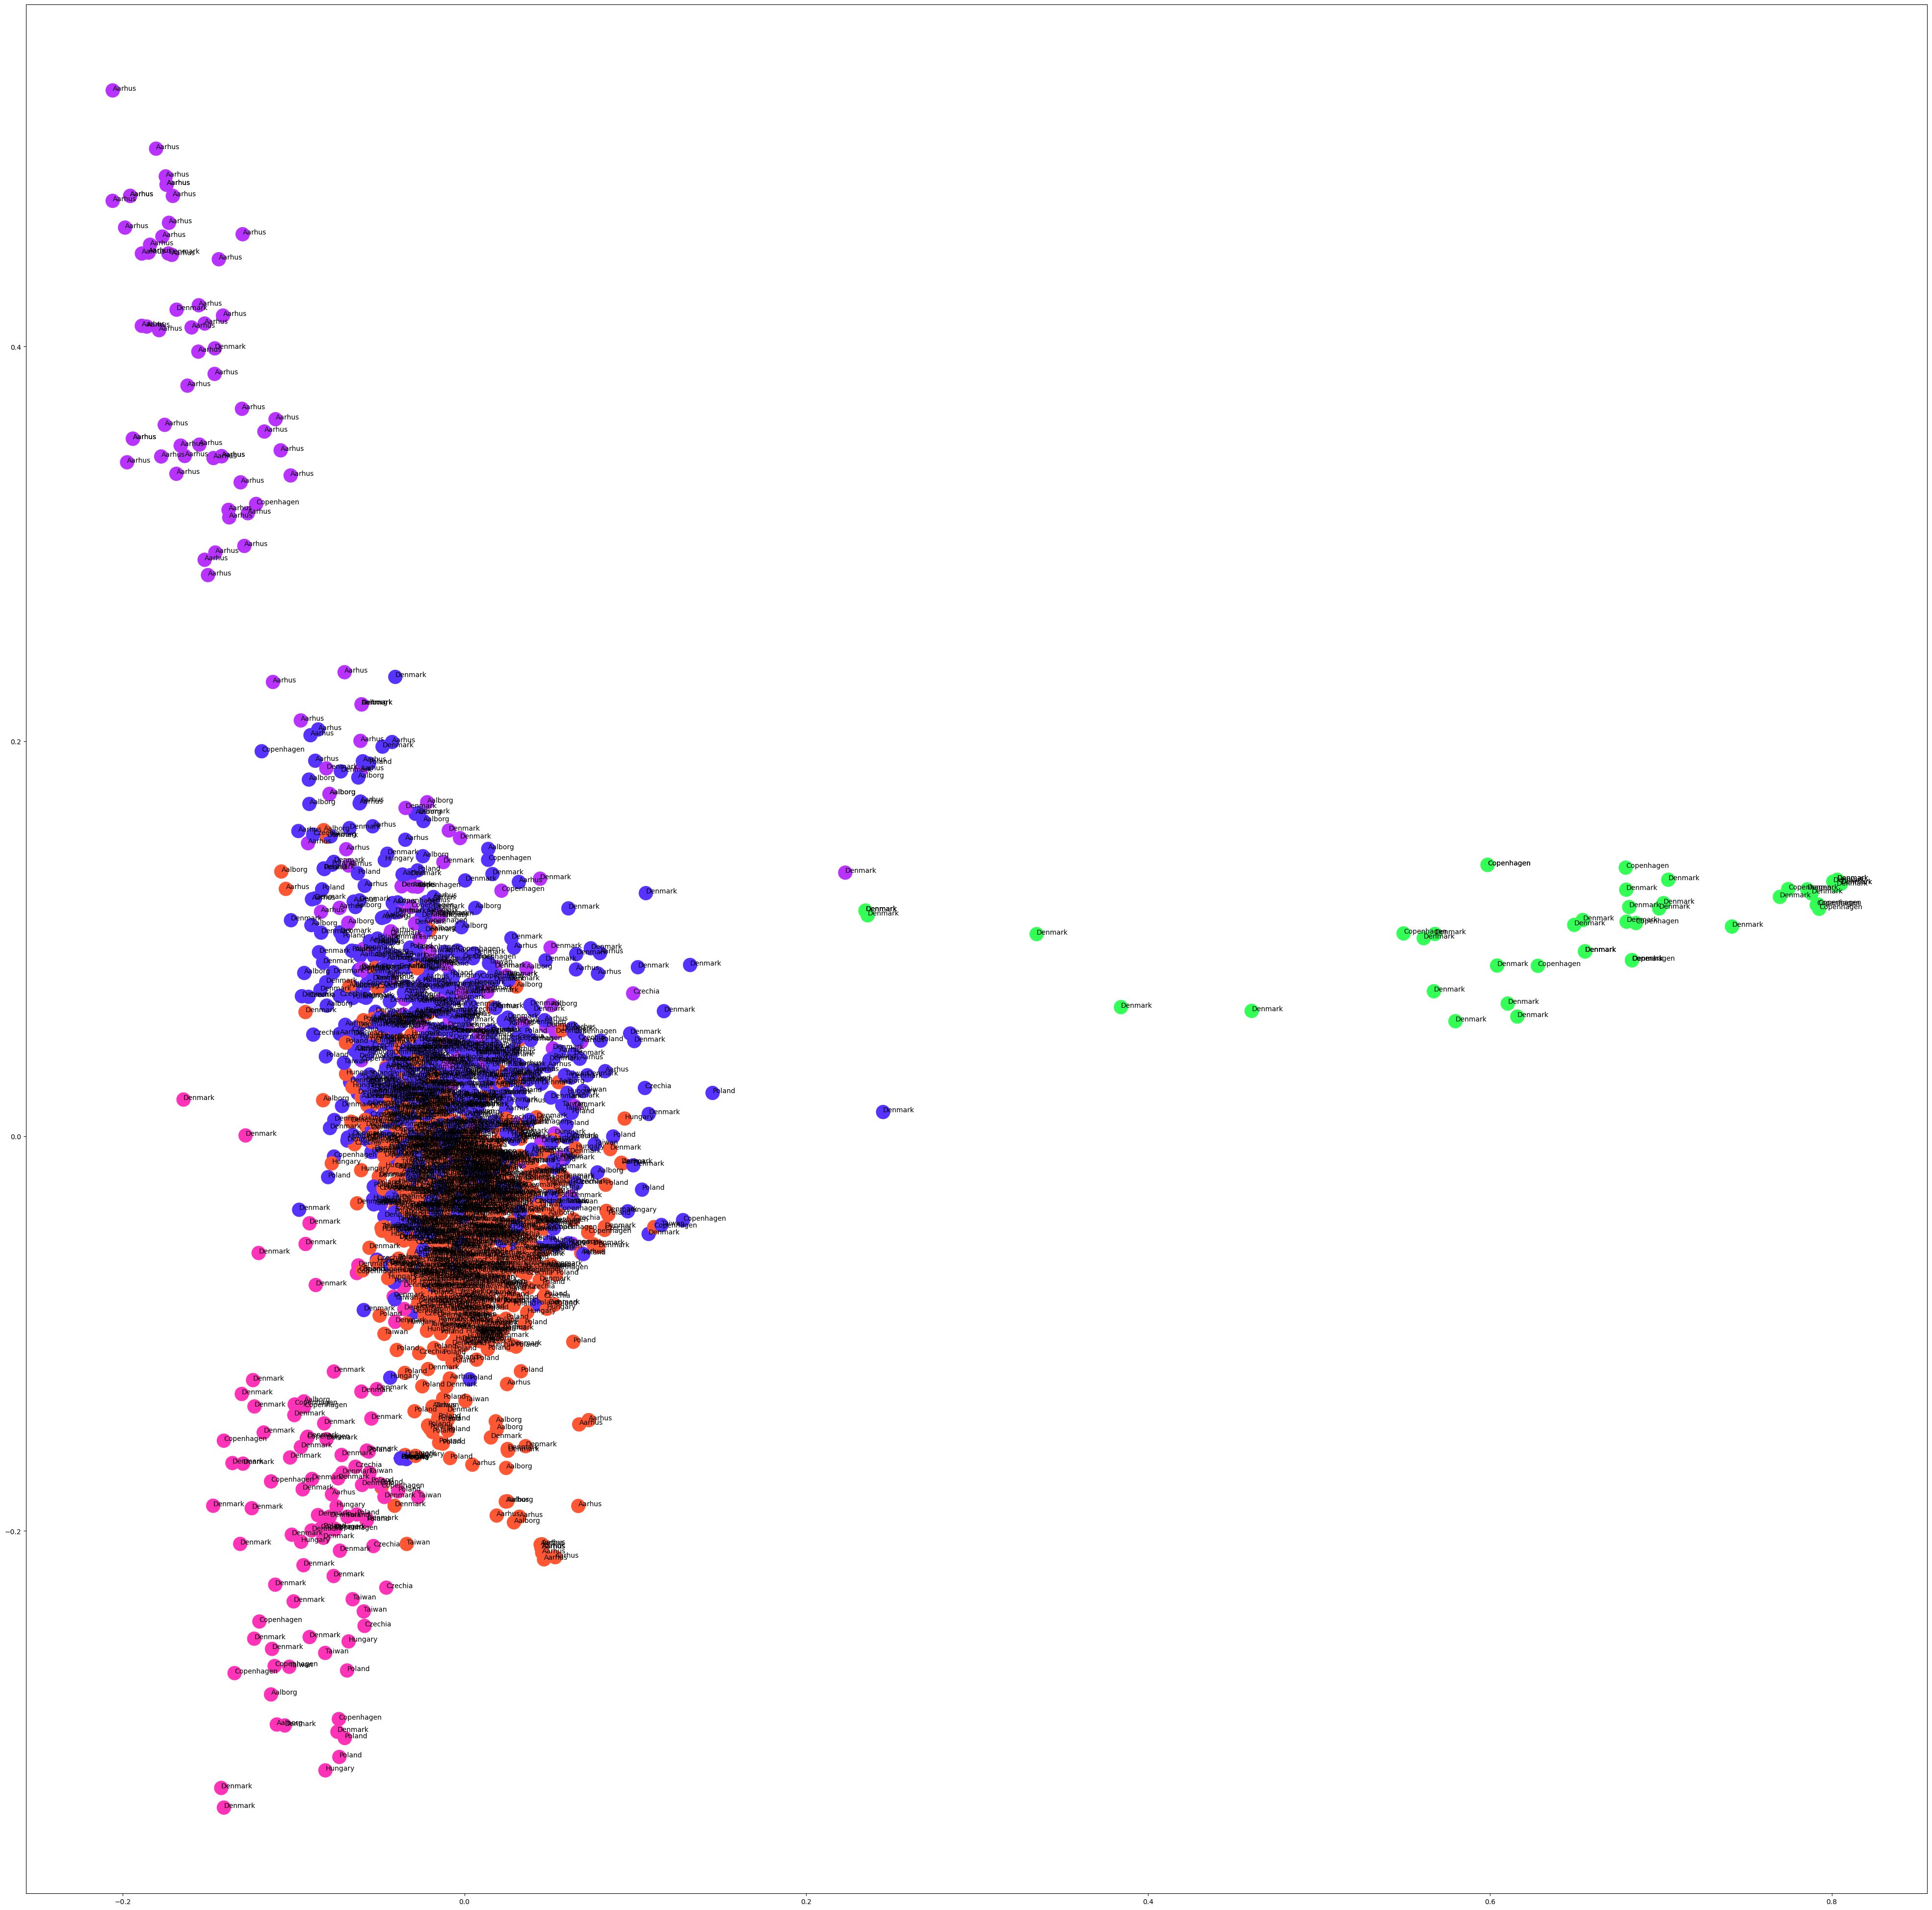

In [6]:
vectors, all_keywords = get_tfidf_vectors(description_adj_strings)

# Fit the model to the TF-IDF vectors
model.fit(vectors)

# Get the indices that sort the cluster centers in descending order
order_centroids = model.cluster_centers_.argsort()[:, ::-1]

# Get the feature names (words) from the TF-IDF vectorizer
terms = vectorizer.get_feature_names_out()

# Write the top terms for each cluster to a text file
with open ("clusters/kmeans_adj_results.txt", "w", encoding="utf-8") as f:
    for i in range(true_k):
        f.write(f"Cluster {i+1}")
        f.write("\n")
        for ind in order_centroids[i, :10]:
            f.write (' %s' % terms[ind],)
            f.write("\n")
        f.write("\n")
        f.write("\n")

# Predict cluster assignments for each document in the TF-IDF vectors
kmean_indicates = model.fit_predict(vectors)

# Perform PCA (Principal Component Analysis) for dimensionality reduction to 2 components
pca = PCA(n_components=2)
scatter_plot_points = pca.fit_transform(vectors.toarray())

# Get job locations and define colors for each cluster
locations = jobs['location_scraped']
colors = [
    "#FF5733",  # Orange
    "#33FF57",  # Green
    "#5733FF",  # Blue
    "#FF33B8",  # Pink
    "#B833FF",  # Purple
]

# Extract x and y coordinates for scatter plot
x_axis = [o[0] for o in scatter_plot_points]
y_axis = [o[1] for o in scatter_plot_points]

# Create a scatter plot with colored points for each cluster and annotations for job locations
fig, ax = plt.subplots(figsize=(50, 50))
ax.scatter(x_axis, y_axis, c=[colors[d] for d in kmean_indicates], s=400)
for i, txt in enumerate(locations):
    ax.annotate(txt[0:10], (x_axis[i], y_axis[i]))

# Save the scatter plot as an image file
plt.savefig("figures/kmeans_adj.png")


## KMEANS - NOUN

In [ ]:
vectors, all_keywords = get_tfidf_vectors(description_noun_strings)

# Fit the model to the TF-IDF vectors
model.fit(vectors)

# Get the indices that sort the cluster centers in descending order
order_centroids = model.cluster_centers_.argsort()[:, ::-1]

# Get the feature names (words) from the TF-IDF vectorizer
terms = vectorizer.get_feature_names_out()

# Write the top terms for each cluster to a text file
with open ("clusters/kmeans_noun_results.txt", "w", encoding="utf-8") as f:
    for i in range(true_k):
        f.write(f"Cluster {i+1}")
        f.write("\n")
        for ind in order_centroids[i, :10]:
            f.write (' %s' % terms[ind],)
            f.write("\n")
        f.write("\n")
        f.write("\n")

# Predict cluster assignments for each document in the TF-IDF vectors
kmean_indicates = model.fit_predict(vectors)

# Perform PCA (Principal Component Analysis) for dimensionality reduction to 2 components
pca = PCA(n_components=2)
scatter_plot_points = pca.fit_transform(vectors.toarray())

# Extract x and y coordinates for scatter plot
x_axis = [o[0] for o in scatter_plot_points]
y_axis = [o[1] for o in scatter_plot_points]

# Create a scatter plot with colored points for each cluster and annotations for job locations
fig, ax = plt.subplots(figsize=(50, 50))

ax.scatter(x_axis, y_axis, c=[colors[d] for d in kmean_indicates], s=400)
for i, txt in enumerate(locations):
    ax.annotate(txt[0:10], (x_axis[i], y_axis[i]))

# Save the scatter plot as an image file
plt.savefig("figures/kmeans_noun.png")

## KMEANS - VERB

In [ ]:
vectors, all_keywords = get_tfidf_vectors(description_verb_strings)

# Fit the model to the TF-IDF vectors
model.fit(vectors)

# Get the indices that sort the cluster centers in descending order
order_centroids = model.cluster_centers_.argsort()[:, ::-1]

# Get the feature names (words) from the TF-IDF vectorizer
terms = vectorizer.get_feature_names_out()

# Write the top terms for each cluster to a text file
with open ("clusters/kmeans_verb_results.txt", "w", encoding="utf-8") as f:
    for i in range(true_k):
        f.write(f"Cluster {i+1}")
        f.write("\n")
        for ind in order_centroids[i, :10]:
            f.write (' %s' % terms[ind],)
            f.write("\n")
        f.write("\n")
        f.write("\n")

# Predict cluster assignments for each document in the TF-IDF vectors
kmean_indicates = model.fit_predict(vectors)

# Perform PCA (Principal Component Analysis) for dimensionality reduction to 2 components
pca = PCA(n_components=2)
scatter_plot_points = pca.fit_transform(vectors.toarray())

# Extract x and y coordinates for scatter plot
x_axis = [o[0] for o in scatter_plot_points]
y_axis = [o[1] for o in scatter_plot_points]

# Create a scatter plot with colored points for each cluster and annotations for job locations
fig, ax = plt.subplots(figsize=(50, 50))
ax.scatter(x_axis, y_axis, c=[colors[d] for d in kmean_indicates], s=400)
for i, txt in enumerate(locations):
    ax.annotate(txt[0:10], (x_axis[i], y_axis[i]))

# Save the scatter plot as an image file
plt.savefig("figures/kmeans_verb.png")